In [228]:
import pandas as pd
import numpy as np
import os
import pyvis
import networkx as nx
from matplotlib import pyplot as plt
from itertools import product

In [229]:
current_directory = os.getcwd()

In [230]:
skus_data = pd.read_csv(f"{current_directory}/data/skus.csv", delimiter = ",")
transactions_data = pd.read_csv(f"{current_directory}/data/transactions.csv", delimiter = ",")

**REVENUE = SALE_PRICE_EX_VAT * QTY**

In [231]:
skus_data.columns

Index(['SKU', 'ITEM_DESCRIPTION', 'DEPARTMENT', 'CATEGORY', 'SUBCATEGORY1',
       'SUBCATEGORY2', 'BRAND', 'ITEM_WEIGHT', 'ITEM_UNIT_OF_MEASURE'],
      dtype='object')

### Other SKUs in transactions that are not part of the list of 500 best-selling items

In [232]:
result = {x for x in transactions_data["SKU"].unique() if x not in skus_data["SKU"].unique()}
result

set()

### Missing SKUs in transactions

In [233]:
result2 = {x for x in skus_data["SKU"].unique() if x not in transactions_data["SKU"].unique()}
skus_data[skus_data["SKU"].isin(result2)]

,SKU,ITEM_DESCRIPTION,DEPARTMENT,CATEGORY,SUBCATEGORY1,SUBCATEGORY2,BRAND,ITEM_WEIGHT,ITEM_UNIT_OF_MEASURE
46,65813,Sizzlers Bacon Treat Maxi,Dog,Treat,Other,Other,Bakers,0.001,KG
47,65815,Bacon/Cheese Whirlers Maxi,Dog,Treat,Other,Other,Bakers,0.001,KG
123,51849,Miss Purfect Strip Teasers,Cat,Treat,Other,Na,Miss Purfect,0.050,KG
134,54646,Beef Meat Only Dinner,Dog,Food,Frozen,Adult,Durham Animal Feeds,0.500,KG
189,30365,Delivery,Misc.,Na,Na,Na,NaN,NaN,NaN
367,50806,Naturals Gig Mv Chkn,Cat,Food,S.S.Wet,Adult,Gourmet,0.810,KG
498,65495,Chicken Mince,Dog,Food,Frozen,Adult,Raw And Simple,1.500,KG


### Count number of unique items sold together per transaction
A purchase will be a unique transaction with possibly multiple items sold at the same time (i.e.: same unique transacation ID).
We want to know the distribution of number of items sold per purchase.

<BarContainer object of 12 artists>

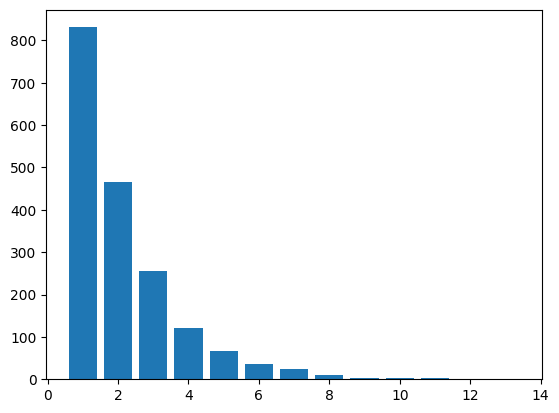

In [234]:
sku_transactions_data = transactions_data.groupby(["TRANSACTION_ID"]).agg({
    "SKU" : lambda x : x.nunique()
}).reset_index().value_counts("SKU")
plt.bar(sku_transactions_data.index, sku_transactions_data.values)

### Percentage of transactions with 2 items or more sold

In [235]:
round(1-sku_transactions_data.loc[1]/sku_transactions_data.sum(), 2)*100

np.float64(54.0)

### Number of times an item has been bought

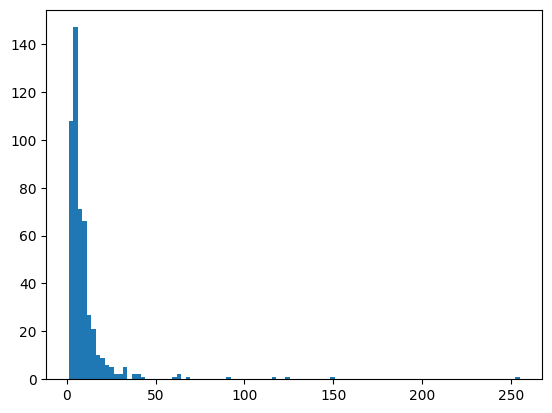

In [237]:
item_purchases = transactions_data.groupby(["SKU"]).agg(
    {"TRANSACTION_ID" : "count"}
).reset_index().rename(columns = {"TRANSACTION_ID" : "TOTAL_TRANSACTION"})

plt.hist(item_purchases["TOTAL_TRANSACTION"], bins = 100);

# Low-frequence items analysis

**REVENUE = SALE_PRICE_EX_VAT * QTY**


In [238]:
transactions_data = transactions_data.merge(item_purchases, on = "SKU", how = "left")

In [254]:
transactions_data[transactions_data["TOTAL_TRANSACTION"] > 5]["REVENUE"].sum()/transactions_data["REVENUE"].sum()

np.float64(0.7951121178296454)

### Check if a transaction ID is unique or uniquer per store

In [255]:
transactions_data.groupby("TRANSACTION_ID").agg({
    "STORE_ID" : lambda x : x.nunique()
    }
)["STORE_ID"].nunique()

1

Transaction ID is indeed unique across all the stores. It is not a unique Transaction ID per store.

### There are negative quantities. Is that returned items? We can drop them as it is only a few transactions.


In [87]:
transactions_data[transactions_data["QTY"]<0]

,TRANSACTION_ID,TRANSACTION_LINE_ID,STORE_ID,SKU,SALE_PRICE_EX_VAT,REVENUE,QTY,DISCOUNT
1017,126149042,446790067,15,36022,7.11700,-2.8468,-0.4,-0.1498
1100,126104768,446708690,13,62955,1.57500,-1.5750,-1.0,0.0000
1175,125741803,445667330,212,65597,0.00000,0.0000,-1.0,0.0000
3957,125608948,445270684,216,65597,0.00000,0.0000,-1.0,0.0000
4700,126028818,446433485,97,64952,1.04165,-2.0833,-2.0,0.0000
4870,125608948,445274062,216,65596,0.00000,0.0000,-1.0,0.0000


### Count number of times a pair of items is bought together

In [318]:
# Create all possible pairs
pairs = list(product(skus_data["SKU"].sort_values(), repeat=2))

# # Create a new DataFrame with the pairs
pairs_df = pd.DataFrame(pairs, columns=["SKU1", "SKU2"])
pairs_df["PurchasesCount"] = 0

pairs_df["SKU1"], pairs_df["SKU2"] = zip(*pairs_df.apply(lambda row: sorted([row["SKU1"], row["SKU2"]]), axis=1))
pairs_df = pairs_df.drop_duplicates()
pairs_df = pairs_df[pairs_df["SKU1"] != pairs_df["SKU2"]]

In [319]:
skus_per_transaction = transactions_data.groupby(["TRANSACTION_ID"]).agg({
    "SKU" : lambda x : set(list(x))
}).reset_index()

skus_per_transaction["SKU"] = skus_per_transaction.SKU.map(lambda x : sorted(x))

## Create all possible pairs (including self-pairs)
skus_per_transaction["AllPairs"] = skus_per_transaction["SKU"].map(lambda x : list(product(x, repeat=2)))

In [320]:
for _, row in skus_per_transaction.iterrows():
    list_pairs = row["AllPairs"]
    for _pair in list_pairs:
        sku_id1 = _pair[0]
        sku_id2 = _pair[1]
        if sku_id1 < sku_id2:
            pairs_df.loc[(pairs_df["SKU1"]==sku_id1) & (pairs_df["SKU2"]==sku_id2), "PurchasesCount"] += 1

In [321]:
pairs_df = pairs_df.merge(item_purchases, left_on = "SKU1", right_on = "SKU", how = "left").drop(columns = "SKU").rename(columns = {"TOTAL_TRANSACTION" : "TOTAL_TRANSACTIONS_SKU1"})
pairs_df = pairs_df.merge(item_purchases, left_on = "SKU2", right_on = "SKU", how = "left").drop(columns = "SKU").rename(columns = {"TOTAL_TRANSACTION" : "TOTAL_TRANSACTIONS_SKU2"})

In [ ]:
pairs_df["RATIO_SKU1"] = pairs_df.apply(lambda x : x.PurchasesCount / x.TOTAL_TRANSACTIONS_SKU1 if x.TOTAL_TRANSACTIONS_SKU1 else 0, axis = 1)
pairs_df["RATIO_SKU2"] = pairs_df.apply(lambda x : x.PurchasesCount / x.TOTAL_TRANSACTIONS_SKU2 if x.TOTAL_TRANSACTIONS_SKU2 else 0, axis = 1)

In [328]:
pairs_df["MAX_RATIO"] = pairs_df.apply(lambda x : max(x.RATIO_SKU1, x.RATIO_SKU2), axis = 1)

In [333]:
def filter_nbre_transactions(df, threshold_transactions):
   df = df[df["TOTAL_TRANSACTIONS_SKU1"]>threshold_transactions]
   df = df[df["TOTAL_TRANSACTIONS_SKU2"]>threshold_transactions]
   return df

In [334]:
pairs_df = filter_nbre_transactions(pairs_df, 4)
pairs_df[pairs_df["MAX_RATIO"]>0.10]

,SKU1,SKU2,PurchasesCount,TOTAL_TRANSACTIONS_SKU1,TOTAL_TRANSACTIONS_SKU2,RATIO_SKU1,RATIO_SKU2,MAX_RATIO
217,7716,51113,1,7.0,60.0,0.142857,0.016667,0.142857
419,7716,63147,1,7.0,33.0,0.142857,0.030303,0.142857
463,7716,65598,1,7.0,255.0,0.142857,0.003922,0.142857
564,8462,20642,1,5.0,7.0,0.200000,0.142857,0.200000
592,8462,27686,1,5.0,7.0,0.200000,0.142857,0.200000
...,...,...,...,...,...,...,...,...
124343,65785,66971,2,16.0,17.0,0.125000,0.117647,0.125000
124400,65801,65805,1,8.0,7.0,0.125000,0.142857,0.142857
124418,65801,66597,1,8.0,22.0,0.125000,0.045455,0.125000
124730,66597,66601,2,22.0,9.0,0.090909,0.222222,0.222222


In [335]:
pairs_df["SKU1"].nunique()

337